In [ ]:
!pip install GPy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 18.5 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1


In [ ]:
import GPy
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt


In [ ]:
def get_scatter(par_ar, val_ar, pnames, cmin, cmax):
  # Number of parameters
  n_params = par_ar.shape[1]
  # Create plots
  fig, axes = plt.subplots(n_params-1, n_params-1, figsize=(8, 8))
  plt.subplots_adjust(wspace=0, hspace=0)
  # Hide the upper triangles
  for i in range(n_params-1):
      for j in range(n_params-1):
          if i < j:
              axes[i, j].axis('off')
  # Plot each combination
  for i in range(n_params):
      for j in range(i+1, n_params):
          ax = axes[j-1, i]
          # Plot all samples
          sc = ax.scatter(par_ar[:,i], par_ar[:,j], c=val_ar,  s=1.0, cmap='viridis', vmin=cmin, vmax = cmax)
          if j < n_params-1:
              ax.set_xticklabels([])
          else:
              ax.set_xlabel(pnames[i])
          if i > 0:
              ax.set_yticklabels([])
          else:
              ax.set_ylabel(pnames[j])

  cbar = fig.colorbar(sc, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
  plt.show()

In [ ]:
params_names = ['wb', 'wc', 'Mnu']

training_params = np.loadtxt('training_sample_2000_corr.dat', unpack=True, usecols=(0,1,3))
training_params = training_params.T
print ('SHAPE OF TRAINING SAMPLE =', training_params.shape)
print (np.min(training_params, axis=0), np.max(training_params, axis=0))

training_rdrag = np.loadtxt('training_rdrag_2000_corr_for_loops.dat')
print ('SHAPE OF TRAINING RDRAG =', training_rdrag.shape)

temp = np.log10(training_rdrag)
mean = np.mean(temp)
std = np.std(temp)

print('mean=', mean)
print('std=', std)


SHAPE OF TRAINING SAMPLE = (2000, 3)
[2.05001954e-02 8.50237798e-02 3.19766441e-05] [0.02414856 0.15499628 0.99972793]
SHAPE OF TRAINING RDRAG = (2000,)
mean= 2.168377278691376
std= 0.016014196248442452


In [ ]:
validation_params = np.loadtxt('validation_sample_1000_for_loops.dat', unpack=True, usecols=(0,1,3))
validation_params = validation_params.T
print ('SHAPE OF VALIDATION SAMPLE =', validation_params.shape)

validation_rdrag = np.loadtxt('validation_rdrag_1000_for_loops.dat')
print ('SHAPE OF VALIDATION RDRAG =', validation_rdrag.shape)

SHAPE OF VALIDATION SAMPLE = (1000, 3)
SHAPE OF VALIDATION RDRAG = (1000,)


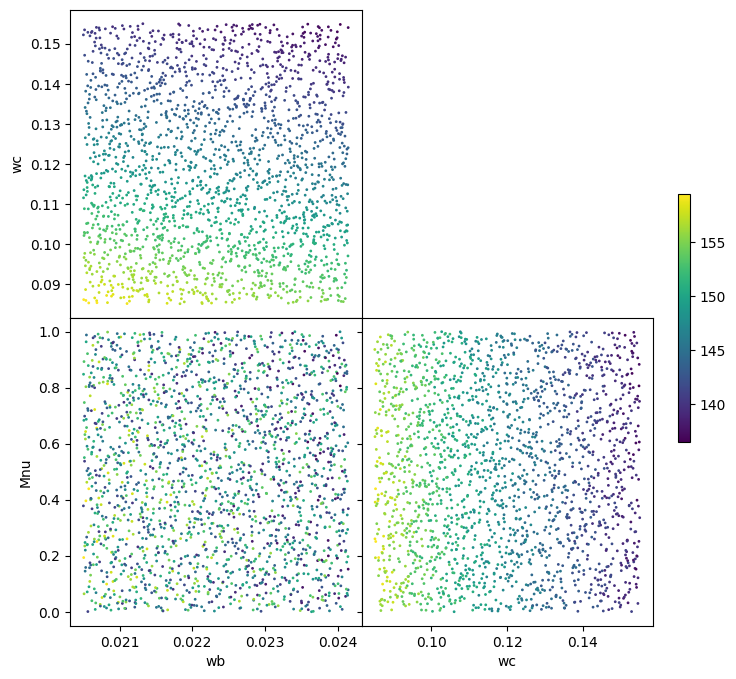

In [ ]:
get_scatter(training_params, training_rdrag, params_names, training_rdrag.min(), training_rdrag.max())

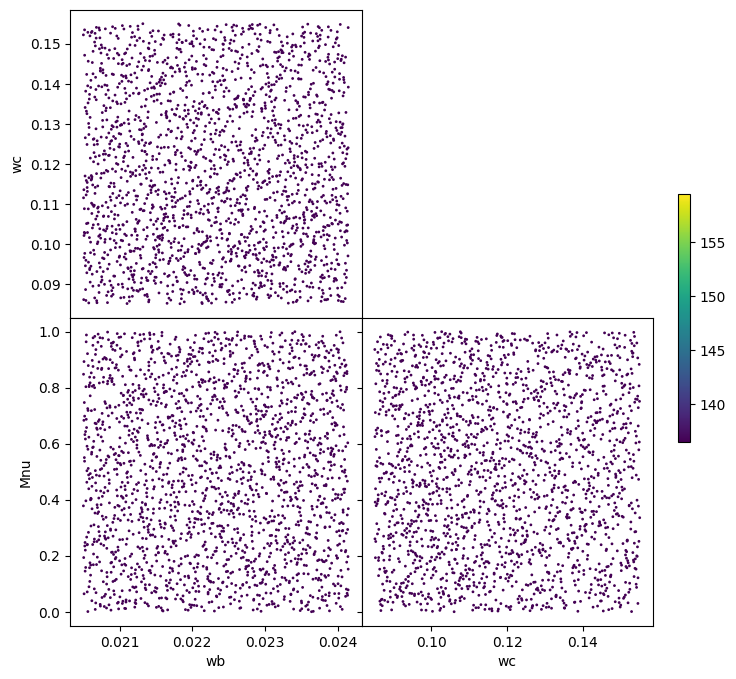

In [ ]:
get_scatter(training_params, temp, params_names, training_rdrag.min(), training_rdrag.max())

In [ ]:
n_params = training_params.shape[1]

temp = np.log10(training_rdrag)
mean = np.mean(temp)
std = np.std(temp)

model_transformed = (temp - mean)/std


kernel = (GPy.kern.RBF(input_dim=n_params,
                variance=np.var(model_transformed),
                lengthscale=np.ones(n_params),
                ARD=True) +
          GPy.kern.Matern32(input_dim=n_params,
                    variance=np.var(model_transformed),
                    lengthscale=np.ones(n_params),
                    ARD=True) +
          GPy.kern.White(input_dim=n_params,
                  variance=np.var(model_transformed)))



emu_rdrag = GPy.models.GPRegression(
            training_params, model_transformed .reshape([len(model_transformed ),1]), kernel)

In [ ]:
emu_rdrag.optimize(max_f_eval=1000)
emu_rdrag.optimize_restarts(num_restarts=2)

 /usr/local/lib/python3.10/dist-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/2, f = -16274.87097810024
Optimization restart 2/2, f = -16274.868448699708


In [ ]:
emulated_rdrag = np.zeros(1000)
for i in range(1000):
    emulated_rdrag[i] = 10.0**(emu_rdrag.predict(validation_params[i][None, :])[0] * std + mean)

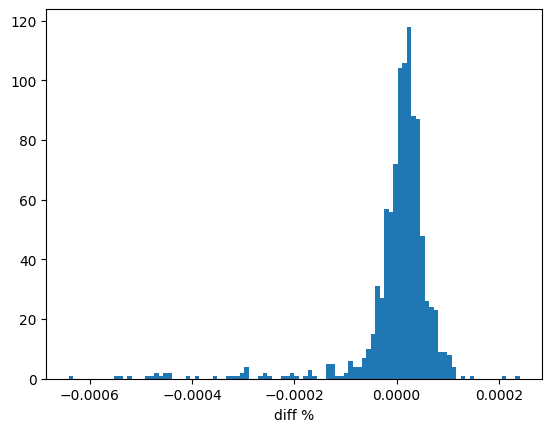

In [ ]:
plt.hist((emulated_rdrag/validation_rdrag-1.0)*100.0, bins=100)
plt.xlabel('diff %')
plt.show()

In [ ]:
print(emu_rdrag[''])
print(emu_rdrag.log_likelihood())

  index  |         GP_regression.sum.rbf.variance  |  constraints  |  priors
  [0]    |                           871.89799145  |      +ve      |        
  -----  |      GP_regression.sum.rbf.lengthscale  |  -----------  |  ------
  [0]    |                             0.09195904  |      +ve      |        
  [1]    |                             0.25532569  |      +ve      |        
  [2]    |                             3.06247120  |      +ve      |        
  -----  |       GP_regression.sum.Mat32.variance  |  -----------  |  ------
  [0]    |                             0.00000000  |      +ve      |        
  -----  |    GP_regression.sum.Mat32.lengthscale  |  -----------  |  ------
  [0]    |                            32.93347686  |      +ve      |        
  [1]    |                           494.43742405  |      +ve      |        
  [2]    |                           932.05979929  |      +ve      |        
  -----  |       GP_regression.sum.white.variance  |  -----------  |  ------